# Feature Engineering

---

*Features*

- 7 new featurs are created:
    * document length, raw
    * document length, clean
    * token, number of
    * token length, max
    * token length, mean
    * token length, std
    * right-side ratio (rsr)
        - see details about this curious metric in [this notebook](./Extra_The_QWERTY_Effect.ipynb)
    
*Results*

- After some visualizations, the first feature (raw document length) appears to be the most useful in separating the target
- After a quick modeling phase, all features but the RSR appear to have the best stats
- These features should be evaluated in combination with Bag-of-Trigrams and Tfidf representations
 

### Setup

In [1]:
import os
import time

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-22


### Load Data

In [2]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("..","data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

### New Features

In [3]:
%%capture output

# custom feature engineering module
import custom.feature_engineering as Fe

try:
    clean_train_docs, X_train_feat = Fe.DocumentToFeaturesCounterTransformer().fit_transform(X_train)
except Warning as e:
    pass # avoids RuntimeErrors because of divisions by zero in calculating means/stds

### Impute `nan` with $0$

In [4]:
[(ix, val) for ix, val in enumerate(X_train[12:15])]

[(0, "K come to nordstrom when you're done"),
 (1, ':-) :-)'),
 (2, 'Okay... I booked all already... Including the one at bugis.')]

In [5]:
[(ix, val) for ix, val in enumerate(clean_train_docs[12:15])]

[(0, 'k come to nordstrom when you are done'),
 (1, ''),
 (2, 'okay i booked all already including the one at bugis')]

In the new feature space - columns:
1. Document length, raw
2. Document length, clean
3. Number of tokens
4. Token length, max
5. Token length, mean
6. Token length, std
7. Right-side ratio

In [6]:
print(X_train_feat[12:15])

[[36.     37.      8.      9.      3.75    2.222   0.5   ]
 [ 7.      0.      0.      0.         nan     nan  0.    ]
 [59.     52.     10.      9.      4.3     2.3259  0.5116]]


In [7]:
# impute with zeros
X_train_feat[np.isnan(X_train_feat)] = 0
print(X_train_feat[12:15])

[[36.     37.      8.      9.      3.75    2.222   0.5   ]
 [ 7.      0.      0.      0.      0.      0.      0.    ]
 [59.     52.     10.      9.      4.3     2.3259  0.5116]]


### Visualising new features

In [8]:
viz = pd.DataFrame(X_train_feat,
                   columns=["doclen_raw","doclen_cln",
                             "n_tokens","token_maxlen",
                             "token_meanlen","token_stdlen","rsr"])
# reload labels
y_train_str = load_data("y_train")
viz["target"] = y_train_str

In [9]:
viz.head()

,doclen_raw,doclen_cln,n_tokens,token_maxlen,token_meanlen,token_stdlen,rsr,target
0,53.0,50.0,9.0,9.0,4.6667,2.2111,0.4524,ham
1,160.0,155.0,33.0,7.0,3.7273,1.3545,0.4309,spam
2,75.0,69.0,14.0,7.0,4.0000,1.7321,0.5000,ham
3,37.0,37.0,8.0,8.0,3.7500,2.4367,0.4333,ham
4,73.0,65.0,13.0,8.0,4.0769,1.8589,0.4906,ham


In [10]:
viz.describe()

,doclen_raw,doclen_cln,n_tokens,token_maxlen,token_meanlen,token_stdlen,rsr
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,79.714359,75.913333,15.860000,7.736667,3.834410,1.791610,0.475802
std,58.108675,55.704255,11.300593,2.620698,0.690138,0.616968,0.087486
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,33.750000,7.000000,6.000000,3.400000,1.414200,0.424575
50%,61.000000,57.000000,12.000000,7.000000,3.777800,1.758200,0.471400
75%,121.000000,114.000000,23.000000,9.000000,4.200000,2.103400,0.520100
max,790.000000,781.000000,172.000000,37.000000,10.500000,6.676200,1.000000


In [11]:
# separate out positives and negatives for plotting
X_pos = viz[viz.target == "spam"]
X_neg = viz[viz.target == "ham"]

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_target_hist(X_pos, X_neg, feat_name, bins=100, log_=False):
    
    if log_:
        pos_ = np.log(X_pos[feat_name])
        neg_ = np.log(X_neg[feat_name])
        xlab = ' '.join(["Log", feat_name])
    else:
        pos_ = X_pos[feat_name]
        neg_ = X_neg[feat_name]
        xlab = feat_name
        
    plt.figure(figsize=(12, 6))    
    plt.hist(pos_, bins=bins, alpha=0.5, label="spam")
    plt.hist(neg_, bins=bins, alpha=0.5, label="ham")
    plt.xlabel(xlab, size=14)
    plt.ylabel("Count", size=14)
    plt.legend(loc='upper right')
    plt.show()

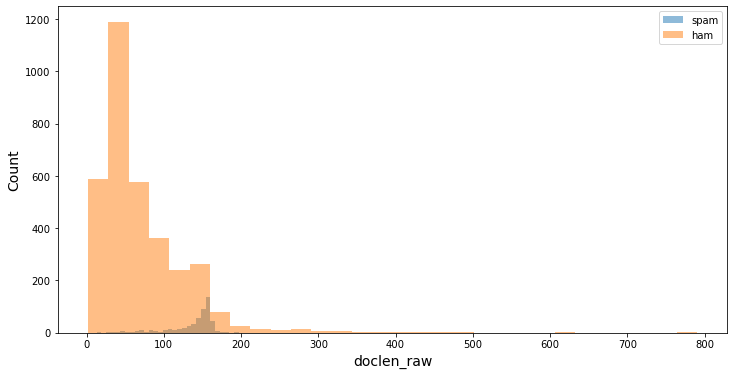

In [70]:
plot_target_hist(X_pos, X_neg, "doclen_raw", bins=30)

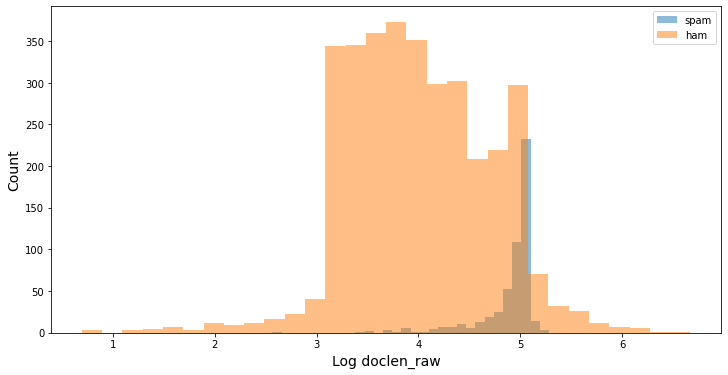

In [69]:
plot_target_hist(X_pos, X_neg, "doclen_raw", bins=30, log_=True)

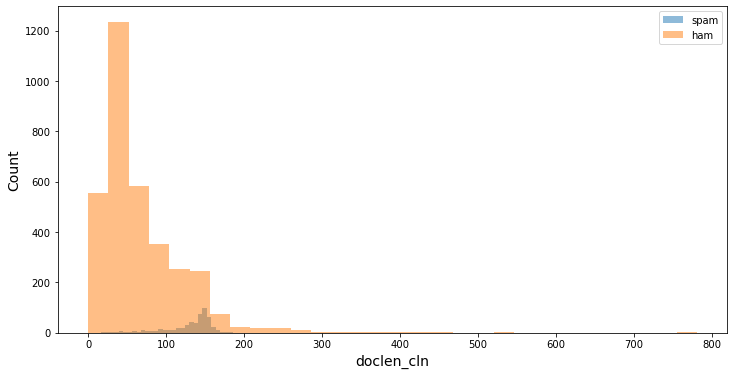

In [68]:
plot_target_hist(X_pos, X_neg, "doclen_cln", bins=30)

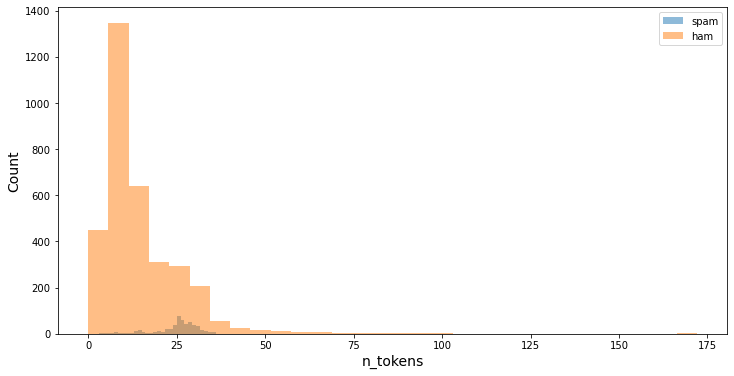

In [64]:
plot_target_hist(X_pos, X_neg, "n_tokens", bins=30)

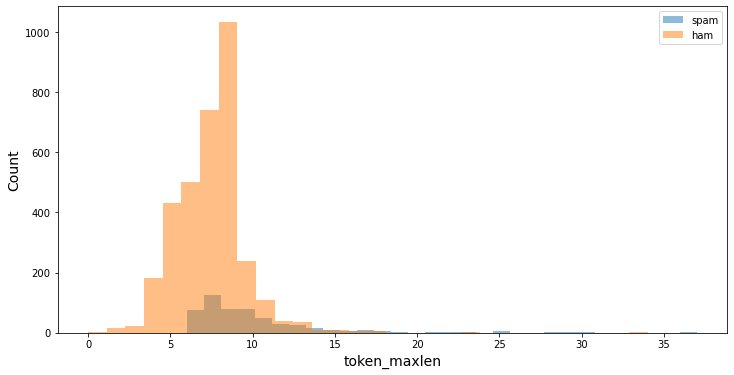

In [63]:
plot_target_hist(X_pos, X_neg, "token_maxlen", bins=30)

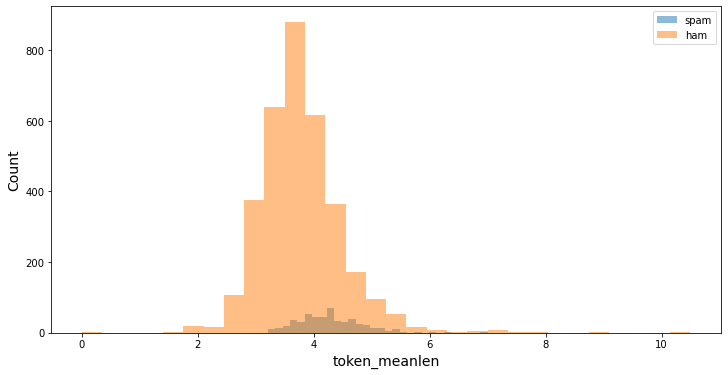

In [65]:
plot_target_hist(X_pos, X_neg, "token_meanlen", bins=30)

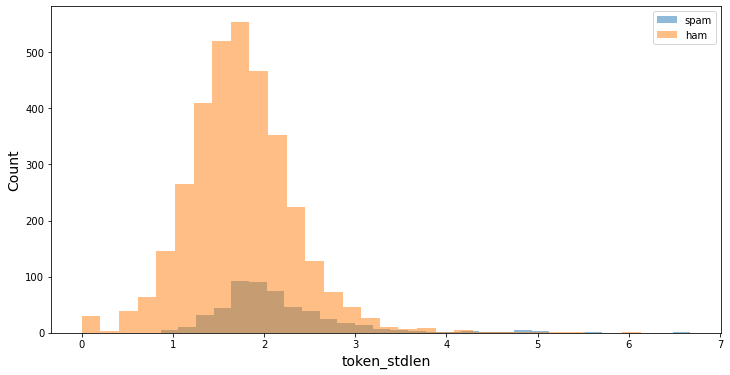

In [66]:
plot_target_hist(X_pos, X_neg, "token_stdlen", bins=30)

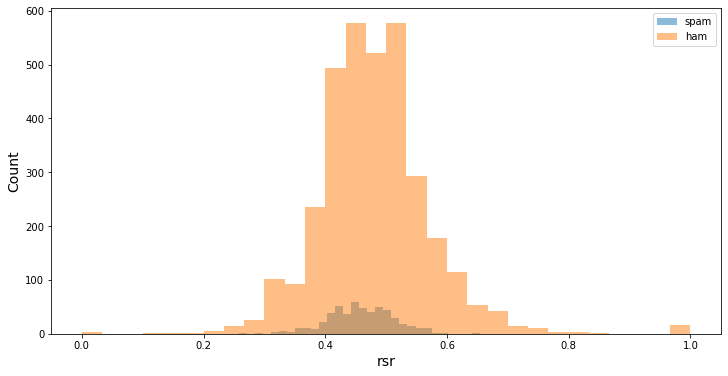

In [67]:
plot_target_hist(X_pos, X_neg, "rsr", bins=30)

It's clear that some of the new features are more useful than others. The right-side ratio is probably the least informative with regards to the target, and the most informative is probably just the raw document length.

TODO: test a couple?

In [23]:
# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y_train = y_train.astype('int')

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)

my_scorer = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score, pos_label=1),
    'specificity': make_scorer(recall_score, pos_label=0)
}

# ALL features
acc = cross_val_score(log_clf, X_train_feat, y_train, cv=10, verbose=0, scoring=my_scorer['accuracy'], n_jobs=-1)
tpr = cross_val_score(log_clf, X_train_feat, y_train, cv=10, verbose=0, scoring=my_scorer['sensitivity'], n_jobs=-1)
tnr = cross_val_score(log_clf, X_train_feat, y_train, cv=10, verbose=0, scoring=my_scorer['specificity'], n_jobs=-1)

print(f'accuracy: {acc.mean():0.4f} (+/- {np.std(acc):0.4f})')
print(f'sensitivity: {tpr.mean():0.4f} (+/- {np.std(tpr):0.4f})')
print(f'specificity: {tnr.mean():0.4f} (+/- {np.std(tnr):0.4f})')

accuracy: 0.8805 (+/- 0.0111)
sensitivity: 0.3231 (+/- 0.0654)
specificity: 0.9657 (+/- 0.0084)


In [71]:
# 10-fold CV for each feature alone
accs, tprs, tnrs = [], [], []
for feat in range(1, 8):
    acc = cross_val_score(log_clf, X_train_feat[:, feat-1:feat], y_train, 
                          cv=10, verbose=0, scoring=my_scorer['accuracy'], n_jobs=-1)
    tpr = cross_val_score(log_clf, X_train_feat[:, feat-1:feat], y_train, 
                          cv=10, verbose=0, scoring=my_scorer['sensitivity'], n_jobs=-1)
    tnr = cross_val_score(log_clf, X_train_feat[:, feat-1:feat], y_train, 
                          cv=10, verbose=0, scoring=my_scorer['specificity'], n_jobs=-1)
    accs.append(round(acc.mean(),4))
    tprs.append(round(tpr.mean(),4))
    tnrs.append(round(tnr.mean(),4))

data = {'feature':['Document length, raw',
                  'Document length, clean',
                  'Number of tokens',
                  'Token length, max',
                  'Token length, mean',
                  'Token length, std',
                  'Right-side ratio'],
        'accuracy':accs,
        'sensitivity':tprs,
        'specificity':tnrs}

df = pd.DataFrame(data)
df

,feature,accuracy,sensitivity,specificity
0,"Document length, raw",0.8462,0.0019,0.9752
1,"Document length, clean",0.8462,0.0000,0.9755
2,Number of tokens,0.8513,0.0000,0.9814
3,"Token length, max",0.8738,0.1123,0.9902
4,"Token length, mean",0.8628,0.0039,0.9941
5,"Token length, std",0.8685,0.0310,0.9965
6,Right-side ratio,0.8674,0.0000,1.0000


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

log_clf = LogisticRegression(solver="liblinear", random_state=42)
Xtr, Xte, ytr, yte = train_test_split(X_train_feat[:,6:7], y_train, test_size=0.33, random_state=42)

log_clf.fit(Xtr, ytr)
ypred = log_clf.predict(Xte)
confusion_matrix(yte, ypred)

array([[1104,    0],
       [ 183,    0]], dtype=int64)

Right-side ratio is just predicting the base rate (all SMS texts are 'ham'), yet it is more accurate than document length in this model. 

The best performing new feature is actually max token length, but it still performs worse than the ensemble:

In [55]:
# max token ('word') length
log_clf = LogisticRegression(solver="liblinear", random_state=42)
Xtr, Xte, ytr, yte = train_test_split(X_train_feat[:,3:4], y_train, test_size=0.33, random_state=42)

log_clf.fit(Xtr, ytr)
ypred = log_clf.predict(Xte)
confusion_matrix(yte, ypred)

array([[1093,   11],
       [ 164,   19]], dtype=int64)

In [72]:
# all features
log_clf = LogisticRegression(solver="liblinear", random_state=42)
Xtr, Xte, ytr, yte = train_test_split(X_train_feat, y_train, test_size=0.33, random_state=42)

log_clf.fit(Xtr, ytr)
ypred = log_clf.predict(Xte)
confusion_matrix(yte, ypred)

array([[1072,   32],
       [ 127,   56]], dtype=int64)

In [ ]:
# 10-fold CV for "all features but one"
accs, tprs, tnrs = [], [], []
for feat in range(1, 8):
    acc = cross_val_score(log_clf, X_train_feat[:, feat-1:feat], y_train, 
                          cv=10, verbose=0, scoring=my_scorer['accuracy'], n_jobs=-1)
    tpr = cross_val_score(log_clf, X_train_feat[:, feat-1:feat], y_train, 
                          cv=10, verbose=0, scoring=my_scorer['sensitivity'], n_jobs=-1)
    tnr = cross_val_score(log_clf, X_train_feat[:, feat-1:feat], y_train, 
                          cv=10, verbose=0, scoring=my_scorer['specificity'], n_jobs=-1)
    accs.append(round(acc.mean(),4))
    tprs.append(round(tpr.mean(),4))
    tnrs.append(round(tnr.mean(),4))

data = {'feature':['Document length, raw',
                  'Document length, clean',
                  'Number of tokens',
                  'Token length, max',
                  'Token length, mean',
                  'Token length, std',
                  'Right-side ratio'],
        'accuracy':accs,
        'sensitivity':tprs,
        'specificity':tnrs}

df = pd.DataFrame(data)
df

In [129]:
accs, tprs, tnrs = [], [], []
all_feat = np.arange(7)
for feat in all_feat:
    all_but_one = tuple(all_feat[np.arange(len(all_feat)) != feat])
    X = X_train_feat[:, all_but_one]
    acc = cross_val_score(log_clf, X, y_train, cv=10, verbose=0, scoring=my_scorer['accuracy'], n_jobs=-1)
    tpr = cross_val_score(log_clf, X, y_train, cv=10, verbose=0, scoring=my_scorer['sensitivity'], n_jobs=-1)
    tnr = cross_val_score(log_clf, X, y_train, cv=10, verbose=0, scoring=my_scorer['specificity'], n_jobs=-1)
    accs.append(round(acc.mean(),4))
    tprs.append(round(tpr.mean(),4))
    tnrs.append(round(tnr.mean(),4))

data = {'All features but':['Document length, raw',
                            'Document length, clean',
                            'Number of tokens',
                            'Token length, max',
                            'Token length, mean',
                            'Token length, std',
                            'Right-side ratio'],
        'accuracy':accs,
        'sensitivity':tprs,
        'specificity':tnrs}

df = pd.DataFrame(data)
df

,All features but,accuracy,sensitivity,specificity
0,"Document length, raw",0.8774,0.2786,0.9690
1,"Document length, clean",0.8815,0.3250,0.9666
2,Number of tokens,0.8677,0.1974,0.9701
3,"Token length, max",0.8774,0.3058,0.9648
4,"Token length, mean",0.8792,0.3173,0.9651
5,"Token length, std",0.8787,0.3077,0.9660
6,Right-side ratio,0.8823,0.3270,0.9672


All features but right-side ratio is a tad better than all features:

| features | accuracy | sensitivity | specificity |
|:------------|:------:|:------:|:------:|
| All features | 0.8805 | 0.3231 | 0.9657 |


---

In [21]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 0 m 13 s
